# Proyecto: EDA con Python

Este proyecto realiza un análisis exploratorio de datos (EDA) de los datasets:

- `bank-additional.csv`
- `customer-details.xlsx` (varias hojas)

Contiene carga de datos, limpieza/transformación, análisis descriptivo, visualizaciones y guardado de resultados.

## 1. Preparación: librerías y rutas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BANK_CSV = "C:/Users/Ronald/Desktop/Proyectos/Python EDA/bank-additional.csv"
CUSTOMER_XLSX = "C:/Users/Ronald/Desktop/Proyectos/Python EDA/customer-details.xlsx"

df_banco = pd.read_csv(BANK_CSV, sep=';')
df_clientes = pd.read_excel(CUSTOMER_XLSX)

print("\nPrimeras filas del dataset bancario:")
print(df_banco.head())

print("\nPrimeras filas del dataset de clientes:")
print(df_clientes.head())



Primeras filas del dataset bancario:
  ,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,latitude,longitude,id_
0  0,,housemaid,MARRIED,basic.4y,0.0,0.0,0.0,tele...                                                                                                                                             
1  1,57.0,services,MARRIED,high.school,,0.0,0.0,t...                                                                                                                                             
2  2,37.0,services,MARRIED,high.school,0.0,1.0,0....                                                                                                                                             
3  3,40.0,admin.,MARRIED,basic.6y,0.0,0.0,0.0,tel...                                                                                                                                      

## 2. Carga de datos

In [2]:
def read_bank_csv_safely(path):
    try:
        df = pd.read_csv(path, sep=',', low_memory=False)
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep=';', low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep=';', low_memory=False)
    return df

bank = read_bank_csv_safely(BANK_CSV)
bank.columns = bank.columns.astype(str).str.strip()
print('bank shape:', bank.shape)
bank.head()

bank shape: (43000, 24)


,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,duration,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,latitude,longitude,id_
0,0,NaN,housemaid,MARRIED,basic.4y,0.0,0.0,0.0,telephone,261,...,1.1,"93,994","-36,4","4,857",5191,no,2-agosto-2019,41.495,-71.233,089b39d8-e4d0-461b-87d4-814d71e0e079
1,1,57.0,services,MARRIED,high.school,NaN,0.0,0.0,telephone,149,...,1.1,"93,994","-36,4",NaN,5191,no,14-septiembre-2016,34.601,-83.923,e9d37224-cb6f-4942-98d7-46672963d097
2,2,37.0,services,MARRIED,high.school,0.0,1.0,0.0,telephone,226,...,1.1,"93,994","-36,4","4,857",5191,no,15-febrero-2019,34.939,-94.847,3f9f49b5-e410-4948-bf6e-f9244f04918b
3,3,40.0,admin.,MARRIED,basic.6y,0.0,0.0,0.0,telephone,151,...,1.1,"93,994","-36,4",NaN,5191,no,29-noviembre-2015,49.041,-70.308,9991fafb-4447-451a-8be2-b0df6098d13e
4,4,56.0,services,MARRIED,high.school,0.0,0.0,1.0,telephone,307,...,1.1,"93,994","-36,4",NaN,5191,no,29-enero-2017,38.033,-104.463,eca60b76-70b6-4077-80ba-bc52e8ebb0eb


In [3]:
# Cargar todas las hojas del Excel de clientes
customers_sheets = pd.read_excel(CUSTOMER_XLSX, sheet_name=None)
list(customers_sheets.keys())

['2012', '2013', '2014']

In [ ]:
# Limpiar cada hoja y concatenar en un único DataFrame con columna Year
clean_sheets = []
for name, df in customers_sheets.items():
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    if 'Dt_Customer' in df.columns:
        df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
    if 'Income' in df.columns:
        df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
    try:
        year = int(name)
    except Exception:
        year = np.nan
    df['Year'] = year
    clean_sheets.append(df)

customers = pd.concat(clean_sheets, ignore_index=True)
print('customers shape:', customers.shape)
customers.head()

customers shape: (43170, 7)


,Income,Kidhome,Teenhome,Dt_Customer,NumWebVisitsMonth,ID,Year
0,161770,1,0,2012-04-04,29,089b39d8-e4d0-461b-87d4-814d71e0e079,2012
1,85477,1,1,2012-12-30,7,e9d37224-cb6f-4942-98d7-46672963d097,2012
2,147233,1,1,2012-02-02,5,3f9f49b5-e410-4948-bf6e-f9244f04918b,2012
3,121393,1,2,2012-12-21,29,9991fafb-4447-451a-8be2-b0df6098d13e,2012
4,63164,1,2,2012-06-20,20,eca60b76-70b6-4077-80ba-bc52e8ebb0eb,2012


## 3. Limpieza y transformación

In [9]:
# --- BANK ---
bank_clean = bank.copy()
bank_clean.columns = bank_clean.columns.str.strip()

# Fechas
if 'date' in bank_clean.columns:
    bank_clean['date'] = pd.to_datetime(bank_clean['date'], errors='coerce')

# Variables binarias comunes -> numéricas
for col in ['default', 'housing', 'loan']:
    if col in bank_clean.columns:
        bank_clean[col] = bank_clean[col].replace({'yes':1,'no':0,'Yes':1,'No':0,'y':1,'n':0})
        bank_clean[col] = pd.to_numeric(bank_clean[col], errors='coerce')

# Variable objetivo y -> binaria adicional
if 'y' in bank_clean.columns:
    bank_clean['y'] = bank_clean['y'].astype(str).str.strip()
    bank_clean['y_bin'] = bank_clean['y'].replace({'yes':1,'no':0,'Yes':1,'No':0})
    bank_clean['y_bin'] = pd.to_numeric(bank_clean['y_bin'], errors='coerce')

# Duración en minutos
if 'duration' in bank_clean.columns:
    bank_clean['duration'] = pd.to_numeric(bank_clean['duration'], errors='coerce')
    bank_clean['duration_min'] = bank_clean['duration'] / 60.0

# Derivar mes/año si existen fechas
if 'contact_month' not in bank_clean.columns and 'date' in bank_clean.columns:
    bank_clean['contact_month'] = bank_clean['date'].dt.month
if 'contact_year' not in bank_clean.columns and 'date' in bank_clean.columns:
    bank_clean['contact_year'] = bank_clean['date'].dt.year

# Forzar numérico en columnas económicas si existen
for col in ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx',
            'cons.conf.idx','euribor3m','nr.employed','latitude','longitude']:
    if col in bank_clean.columns:
        bank_clean[col] = pd.to_numeric(bank_clean[col], errors='coerce')

# Duplicados
bank_clean = bank_clean.drop_duplicates()

# --- CUSTOMERS ---
customers_clean = customers.copy()
customers_clean.columns = customers_clean.columns.str.strip()
customers_clean = customers_clean.drop_duplicates()
if 'Dt_Customer' in customers_clean.columns:
    customers_clean['Dt_Customer'] = pd.to_datetime(customers_clean['Dt_Customer'], errors='coerce')
for col in ['Income','Kidhome','Teenhome','NumWebVisitsMonth','Year']:
    if col in customers_clean.columns:
        customers_clean[col] = pd.to_numeric(customers_clean[col], errors='coerce')

print('bank_clean shape:', bank_clean.shape)
print('customers_clean shape:', customers_clean.shape)
bank_clean.head()

C:\Users\Ronald\AppData\Local\Temp\ipykernel_9696\2520359812.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_clean['date'] = pd.to_datetime(bank_clean['date'], errors='coerce')


bank_clean shape: (43000, 28)
customers_clean shape: (43170, 7)


C:\Users\Ronald\AppData\Local\Temp\ipykernel_9696\2520359812.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bank_clean['y_bin'] = bank_clean['y'].replace({'yes':1,'no':0,'Yes':1,'No':0})


,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,duration,...,nr.employed,y,date,latitude,longitude,id_,y_bin,duration_min,contact_month,contact_year
0,0,NaN,housemaid,MARRIED,basic.4y,0.0,0.0,0.0,telephone,261,...,5191.0,no,NaT,41.495,-71.233,089b39d8-e4d0-461b-87d4-814d71e0e079,0,4.350000,NaN,NaN
1,1,57.0,services,MARRIED,high.school,NaN,0.0,0.0,telephone,149,...,5191.0,no,NaT,34.601,-83.923,e9d37224-cb6f-4942-98d7-46672963d097,0,2.483333,NaN,NaN
2,2,37.0,services,MARRIED,high.school,0.0,1.0,0.0,telephone,226,...,5191.0,no,NaT,34.939,-94.847,3f9f49b5-e410-4948-bf6e-f9244f04918b,0,3.766667,NaN,NaN
3,3,40.0,admin.,MARRIED,basic.6y,0.0,0.0,0.0,telephone,151,...,5191.0,no,NaT,49.041,-70.308,9991fafb-4447-451a-8be2-b0df6098d13e,0,2.516667,NaN,NaN
4,4,56.0,services,MARRIED,high.school,0.0,0.0,1.0,telephone,307,...,5191.0,no,NaT,38.033,-104.463,eca60b76-70b6-4077-80ba-bc52e8ebb0eb,0,5.116667,NaN,NaN


## 4. Análisis descriptivo

In [21]:
print('=== BANK: describe numéricas ===')
print(bank_clean.select_dtypes(include='number').describe())

print('\n=== CUSTOMERS: describe numéricas ===')
print(customers_clean.select_dtypes(include='number').describe())


=== BANK: describe numéricas ===
         Unnamed: 0           age       default       housing          loan  \
count  43000.000000  37880.000000  34019.000000  41974.000000  41974.000000   
mean   20651.099047     39.977112      0.000088      0.535998      0.155620   
std    11868.770913     10.437957      0.009390      0.498708      0.362499   
min        0.000000     17.000000      0.000000      0.000000      0.000000   
25%    10381.750000     32.000000      0.000000      0.000000      0.000000   
50%    20642.500000     38.000000      0.000000      1.000000      0.000000   
75%    30930.250000     47.000000      0.000000      1.000000      0.000000   
max    41187.000000     98.000000      1.000000      1.000000      1.000000   

           duration      campaign         pdays      previous  emp.var.rate  \
count  43000.000000  43000.000000  43000.000000  43000.000000  43000.000000   
mean     257.739279      2.567233    962.330953      0.174023      0.077128   
std      258.66603

In [20]:
# Distribución de categóricas clave
for col in ['job','marital','education','contact','poutcome','y']:
    if col in bank_clean.columns:
        print(f"\nDistribución de {col}:")
        print(bank_clean[col].value_counts(dropna=False).head(20))


Distribución de job:
job
admin.           10873
blue-collar       9654
technician        7026
services          4162
management        3050
retired           1790
entrepreneur      1522
self-employed     1489
housemaid         1123
unemployed        1063
student            903
NaN                345
Name: count, dtype: int64

Distribución de marital:
marital
MARRIED     25999
SINGLE      12105
DIVORCED     4811
NaN            85
Name: count, dtype: int64

Distribución de education:
education
university.degree      12722
high.school             9925
basic.9y                6309
professional.course     5477
basic.4y                4356
basic.6y                2386
NaN                     1807
illiterate                18
Name: count, dtype: int64

Distribución de contact:
contact
cellular     27396
telephone    15604
Name: count, dtype: int64

Distribución de poutcome:
poutcome
NONEXISTENT    37103
FAILURE         4461
SUCCESS         1436
Name: count, dtype: int64

Distribución de y:
y

In [19]:
# Tasa de suscripción por segmento
def rate_by(col):
    if col in bank_clean.columns and 'y_bin' in bank_clean.columns:
        grp = bank_clean.groupby(col, dropna=False)['y_bin'].mean().sort_values(ascending=False)
        print(f"\nTasa de suscripción por {col} (%):")
        print((grp*100).round(2))

for dim in ['job','marital','education','contact','contact_month']:
    rate_by(dim)


Tasa de suscripción por job (%):
job
student          31.34
retired          25.20
unemployed       14.39
admin.           13.01
NaN              11.30
management       11.21
technician       10.85
self-employed    10.81
housemaid         9.88
entrepreneur      8.28
services          8.07
blue-collar       6.89
Name: y_bin, dtype: float64

Tasa de suscripción por marital (%):
marital
NaN         15.29
SINGLE      13.93
MARRIED     10.21
DIVORCED    10.18
Name: y_bin, dtype: float64

Tasa de suscripción por education (%):
education
illiterate             22.22
NaN                    14.44
university.degree      13.74
professional.course    11.32
high.school            10.84
basic.4y               10.28
basic.6y                8.13
basic.9y                7.81
Name: y_bin, dtype: float64

Tasa de suscripción por contact (%):
contact
cellular     14.74
telephone     5.16
Name: y_bin, dtype: float64

Tasa de suscripción por contact_month (%):
contact_month
NaN    11.27
Name: y_bin, dtype:

## 5. Visualizaciones (matplotlib)

In [18]:
# Helper para guardar figuras directamente en el directorio actual
def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=120)
    plt.show()
    plt.close()



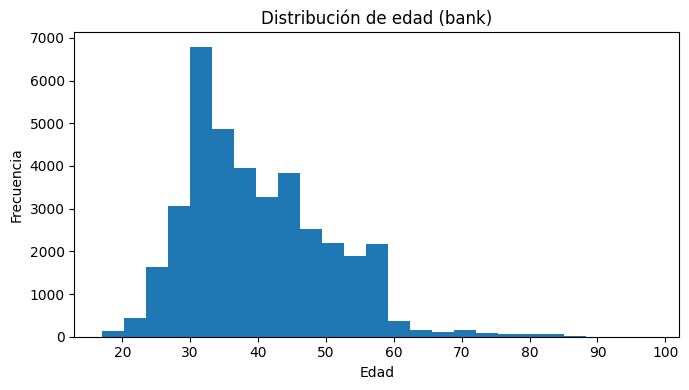

In [16]:
# Histograma de edad
if 'age' in bank_clean.columns:
    plt.figure(figsize=(7,4))
    data = bank_clean['age'].dropna()
    plt.hist(data, bins=25)
    plt.title('Distribución de edad (bank)')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    savefig('hist_age.png')


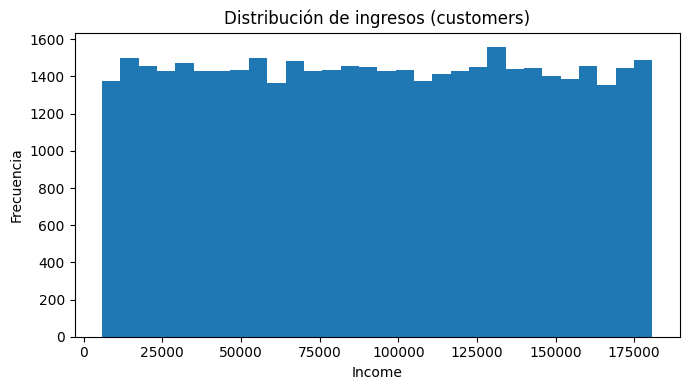

In [15]:
# Histograma de ingresos
if 'Income' in customers_clean.columns:
    plt.figure(figsize=(7,4))
    data = customers_clean['Income'].dropna()
    plt.hist(data, bins=30)
    plt.title('Distribución de ingresos (customers)')
    plt.xlabel('Income')
    plt.ylabel('Frecuencia')
    savefig('hist_income.png')

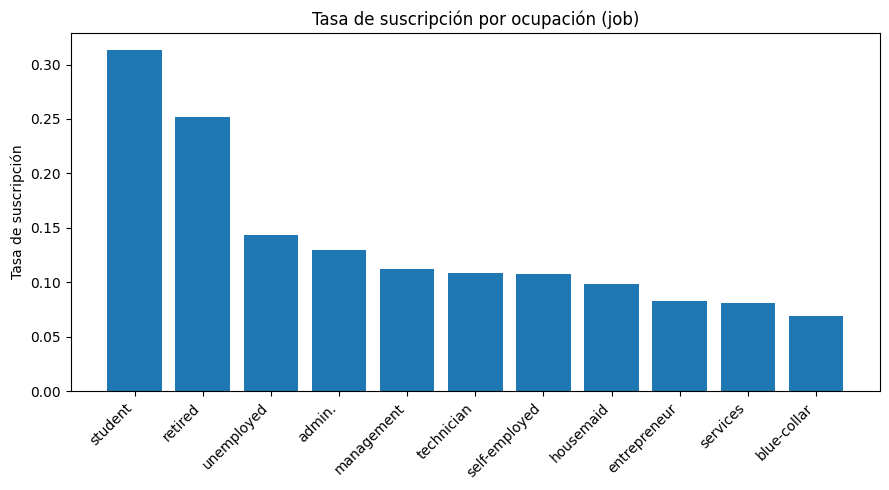

In [14]:
# Barras: tasa por job
if 'job' in bank_clean.columns and 'y_bin' in bank_clean.columns:
    rate = bank_clean.groupby('job')['y_bin'].mean().sort_values(ascending=False)
    plt.figure(figsize=(9,5))
    plt.bar(rate.index.astype(str), rate.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Tasa de suscripción')
    plt.title('Tasa de suscripción por ocupación (job)')
    savefig('bar_target_by_job.png')

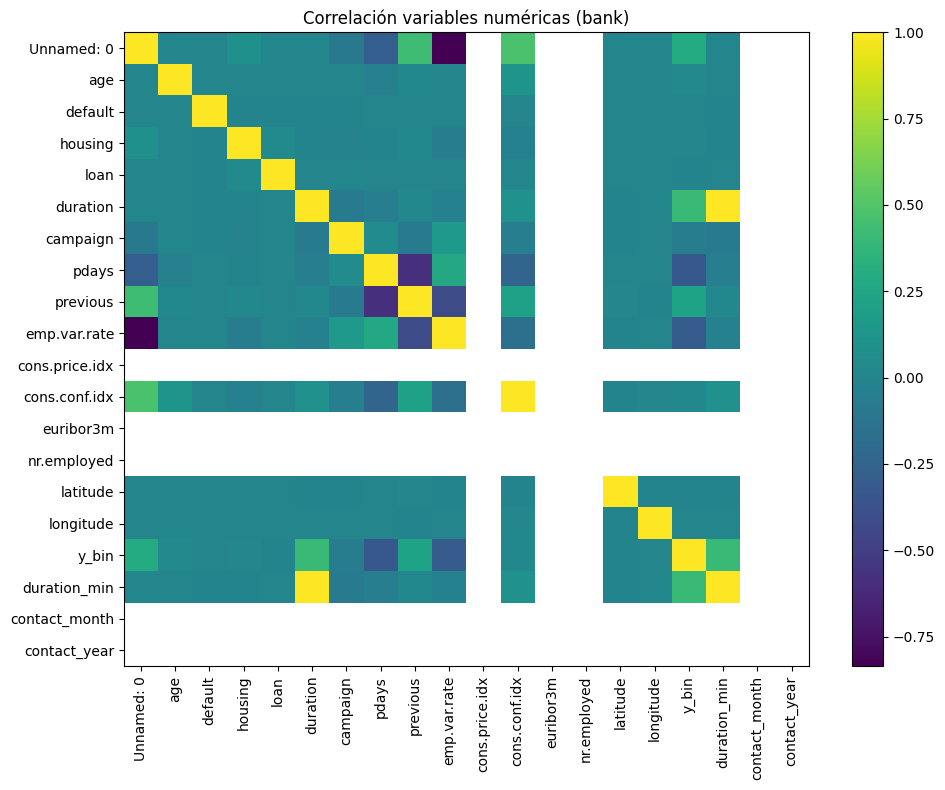

In [13]:
# Heatmap de correlaciones
corr = bank_clean.corr(numeric_only=True)
if corr.shape[0] > 1:
    plt.figure(figsize=(10,8))
    im = plt.imshow(corr, aspect='auto')
    plt.title('Correlación variables numéricas (bank)')
    plt.colorbar(im)
    ticks = range(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=90)
    plt.yticks(ticks, corr.columns)
    savefig('corr_heatmap_bank.png')

## 6. Guardar datos procesados

In [18]:
bank_clean.to_csv('bank_clean.csv', index=False)
customers_clean.to_csv('customers_clean.csv', index=False)
print('Archivos guardados en el directorio actual.')
print('EDA completado.')

Archivos guardados en el directorio actual.
EDA completado.
